30/09/2022

# Generate & correct figures

Uso questo script per:
- calcolare il self-ratio del plot del puff nella line-scan che ho estratto dal movie 05
- salvare delle immagini 3D dei video con Napari da usare per la separazione in chunks

Author: Prisca Dotti  
Last modified: 03.10.2023

## TODO:

https://github.com/napari/napari-animation

https://github.com/guiwitz/naparimovie

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

In [2]:
import os
import imageio
import matplotlib.pyplot as plt
import napari
import cv2

import numpy as np
from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_dilation, binary_erosion
import cc3d
from skimage.io import imsave
from matplotlib import cm

from data.data_processing_tools import (
    simple_nonmaxima_suppression,
    get_otsu_argmax_segmentation,
)
from utils.visualization_tools import (
    get_spark_signal,
    set_edges_to_white,
    get_discrete_cmap,
    get_spark_2d_signal,
    ball,
)
from evaluation.metrics_tools import compute_iou, compute_inter_min
from config import config

## Compute self-ratio

### Import line-scan

In [6]:
linescan_f = "05_video_puff_line-scan.tif"
linescan_path = os.path.join("puff_example", linescan_f)
linescan = np.asarray(imageio.volread(linescan_path))

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [7]:
linescan.shape

(301, 500)

In [11]:
# import original movie to get background value
movie_f = "05_video.tif"
movie_path = os.path.join("puff_example", movie_f)
movie = np.asarray(imageio.volread(movie_path))

In [12]:
movie.shape

(500, 64, 512)

### Compute self-ratio

In [24]:
# background : take value along t of average of left-most vertical line
vertical_line = movie[:, :, 0]
y_average = np.mean(vertical_line, axis=1)  # vector of size 500

# propagate along space
background = np.tile(y_average, (linescan.shape[0], 1))

In [40]:
# basic fluorescence: take average of line-scan between columns 21-42
# (no events)
no_events_roi = linescan[:, 21:42]
t_average = np.mean(no_events_roi, axis=1)

# propagate along space
f_0 = np.tile(t_average, (linescan.shape[1], 1)).transpose()

In [43]:
# compute self-ratio
self_ratio = (linescan - f_0) / (f_0 - background)

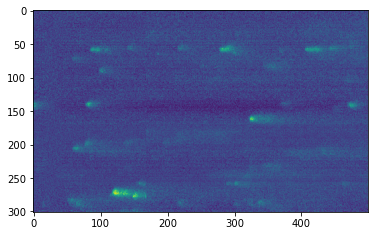

In [47]:
plt.imshow(self_ratio)

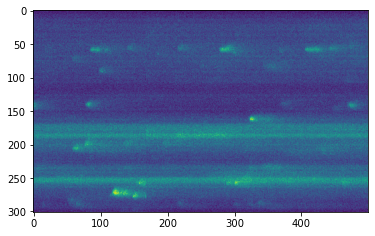

In [48]:
plt.imshow(linescan)

### Save new linescan on disk

In [58]:
imageio.imwrite(os.path.join("puff_example", "self-ratio.png"), self_ratio)

Lossy conversion from float64 to uint8. Range [-0.6186449800584518, 2.430268030125775]. Convert image to uint8 prior to saving to suppress this warning.


## Save 3D chunks of videos

In [9]:
# movie_f = "02_video.tif"
# movie_dir = "ORIGINAL_MOVIE_SAMPLES"
# movie_path = os.path.join(movie_dir, movie_f)

In [10]:
# movie = np.asarray(imageio.volread(movie_path))

In [11]:
# movie.shape

#### open preds instead of original movie

In [5]:
sparks_f = "TEMP_new_annotated_peaks_physio_100000_05_sparks.tif"
puffs_f = "TEMP_new_annotated_peaks_physio_100000_05_puffs.tif"
waves_f = "TEMP_new_annotated_peaks_physio_100000_05_waves.tif"
movie_dir = "ORIGINAL_MOVIE_SAMPLES"

In [5]:
sparks = np.asarray(imageio.volread(os.path.join(movie_dir, sparks_f)))
puffs = np.asarray(imageio.volread(os.path.join(movie_dir, puffs_f)))
waves = np.asarray(imageio.volread(os.path.join(movie_dir, waves_f)))

In [6]:
bg = 1 - sparks - puffs - waves

In [98]:
# TODO: create correct file!!!!!
separated_preds_f = (
    "TEMP_new_annotated_peaks_physio_100000_05_colored_preds_white_background.tif"
)
separated_preds = np.asarray(
    imageio.volread(os.path.join(movie_dir, separated_preds_f))
)

#### compute segmentation

In [36]:
preds = {"sparks": sparks, "puffs": puffs, "waves": waves, "background": bg}

In [50]:
class_preds = get_otsu_argmax_segmentation(preds, return_classes=False)

#### convert separated preds to int matrix

In [99]:
np.unique(separated_preds)

array([ 23,  41,  62,  78, 149, 223, 229, 255], dtype=uint8)

In [96]:
separated_preds = (
    separated_preds[..., 0]
    + 255 * separated_preds[..., 1]
    + 255 * 255 * separated_preds[..., 1]
)

In [92]:
for new_idx, old_idx in enumerate(np.unique(separated_preds)):
    separated_preds = np.where(separated_preds == old_idx, new_idx, separated_preds)

### get chunks

In [12]:
# chunks_duration = 256
# step = 32

In [13]:
# chunk_1 = np.copy(movie[0:chunks_duration])
# chunk_2 = np.copy(movie[step:step+chunks_duration])
# chunk_3 = np.copy(movie[2*step:2*step+chunks_duration])

### set movie edges to white

In [14]:
# white = np.max(movie)

In [15]:
white = 1

In [16]:
# set_edges_to_white(input_movie=movie, white=white)

In [17]:
# set_edges_to_white(input_movie=chunk_1, white=white)
# set_edges_to_white(input_movie=chunk_2, white=white)
# set_edges_to_white(input_movie=chunk_3, white=white)

In [18]:
set_edges_to_white(input_movie=sparks, white=white)
set_edges_to_white(input_movie=puffs, white=white)
set_edges_to_white(input_movie=waves, white=white)
set_edges_to_white(input_movie=bg, white=white)

In [ ]:
set_edges_to_white(input_movie=np.array(class_preds), white=4, thickness=2)

NameError: name 'class_preds' is not defined

In [38]:
set_edges_to_white(input_movie=separated_preds, white=[1, 1, 1], thickness=2)

#### set prediction background to transparent

In [39]:
alpha_mask = np.where(separated_preds == 255, 0, separated_preds)
alpha_mask = np.sum(alpha_mask, axis=-1).astype(bool)

In [44]:
test = np.concatenate((separated_preds, alpha_mask[..., None]), axis=-1)

In [45]:
np.shape(alpha_mask[..., None]), np.shape(separated_preds), test.shape

((488, 64, 512, 1), (488, 64, 512, 3), (488, 64, 512, 4))

### visualise movie

In [20]:
cmap = get_discrete_cmap(name="gray", lut=16)

In [21]:
# viewer = napari.Viewer()
# viewer.theme = 'light'
# viewer.add_image(movie,
#                 name='movie',
#                 colormap=('colors',cmap)
#                )

# viewer.add_image(chunk_1,
#                 name='chunk 1',
#                 colormap=('colors',cmap)
#                )

# viewer.add_image(chunk_2,
#                 name='chunk 2',
#                 colormap=('colors',cmap)
#                )

# viewer.add_image(chunk_3,
#                 name='chunk 3',
#                 colormap=('colors',cmap)
#                )

In [23]:
viewer = napari.Viewer()
viewer.theme = "light"

viewer.add_image(sparks, name="sparks", colormap=("colors", cmap))

viewer.add_image(puffs, name="puffs", colormap=("colors", cmap))

viewer.add_image(waves, name="waves", colormap=("colors", cmap))

viewer.add_image(bg, name="bg", colormap=("colors", cmap))

<Image layer 'bg' at 0x24ebdbec3d0>

In [8]:
viewer = napari.Viewer()
viewer.theme = "light"

C:\Users\dotti\.conda\envs\sparks\lib\site-packages\napari\_qt\__init__.py:54: UserWarning: 

IMPORTANT:
You are using QT version 5.9.7, but version 5.15.6 was also found in your environment.
This usually happens when you 'conda install' something that also depends on PyQt
*after* you have pip installed napari (such as jupyter notebook).
You will likely run into problems and should create a fresh environment.
If you want to install conda packages into the same environment as napari,
please add conda-forge to your channels: https://conda-forge.org

  warn(message=warn_message)


In [53]:
viewer.add_labels(class_preds, name="preds")

<Labels layer 'preds' at 0x24eca1bbf40>

In [41]:
viewer.add_labels(alpha_mask, name="alpha mask")

<Labels layer 'alpha mask [2]' at 0x19259732280>

In [17]:
viewer.add_image(separated_preds, name="separated preds")

<Image layer 'separated preds [2]' at 0x192592f1850>

In [49]:
test[..., -1]

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 0, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 0, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 

In [54]:
screenshot = viewer.screenshot()
# viewer.add_image(screenshot, rgb=True, name='screenshot')

In [55]:
# out_dir = "movie_example"
out_dir = "unet_predictions_figures"
out_f = os.path.join(out_dir, "colored_class_preds.png")

imsave(out_f, screenshot)

## Examples of thresholding on annotations

Plot del fatto che applicare diversi threshold al segnale ha grandi influenze sulle annotazioni

### load smooth movie

In [20]:
# frames ignored by loss function
ignore_frames = 6

In [21]:
data_dir = "ORIGINAL_MOVIE_SAMPLES"
smooth_movie_f = "05_smoothed_video.tif"
smooth_movie_path = os.path.join(data_dir, smooth_movie_f)

smooth_movie = np.asarray(imageio.volread(smooth_movie_path))
smooth_movie = smooth_movie[ignore_frames:-ignore_frames]

In [22]:
smooth_movie.shape

(488, 64, 512)

### load predictions

In [30]:
# preds
preds_f = "TEMP_new_annotated_peaks_physio_100000_05_colored_preds_white_background.tif"
preds_path = os.path.join(data_dir, preds_f)

preds = np.asarray(imageio.volread(preds_path))

# convert preds to int array
preds = preds[..., 0] + 255 * preds[..., 1] + 255 * 255 * preds[..., 2]

for idx, val in enumerate(np.unique(preds)):
    preds[preds == val] = idx

### select event to plot

In [33]:
# spark in movie 05 at z=96 (+ ignore_frames), y=22, x=306
loc = [96, 22, 306]

In [41]:
# get prediction at the selected location
connectivity = 26
labels = cc3d.connected_components(preds, connectivity=connectivity, return_N=False)

n_event = labels[loc[0], loc[1], loc[2]]

### get selected event predicted mask

In [46]:
pred_mask = labels == n_event

In [57]:
# get smooth movie values of predicted event
event_movie = smooth_movie[pred_mask]

### plot event signal along time around its peak

In [66]:
event_peak = simple_nonmaxima_suppression(
    input_array=smooth_movie,
    mask=pred_mask,
    min_distance=10,
    threshold=0.0,
    sigma=2,
)[0]

In [68]:
event_peak = event_peak[0]

In [199]:
frames, signal = get_spark_signal(
    video=smooth_movie,
    sparks_labelled=pred_mask,
    center=event_peak,
    radius=5,
    context_duration=10,
    return_info=False,
)

In [205]:
frames_ms = config.time_frame * (frames - frames.min())

In [219]:
out_dir = "annotations_figures"

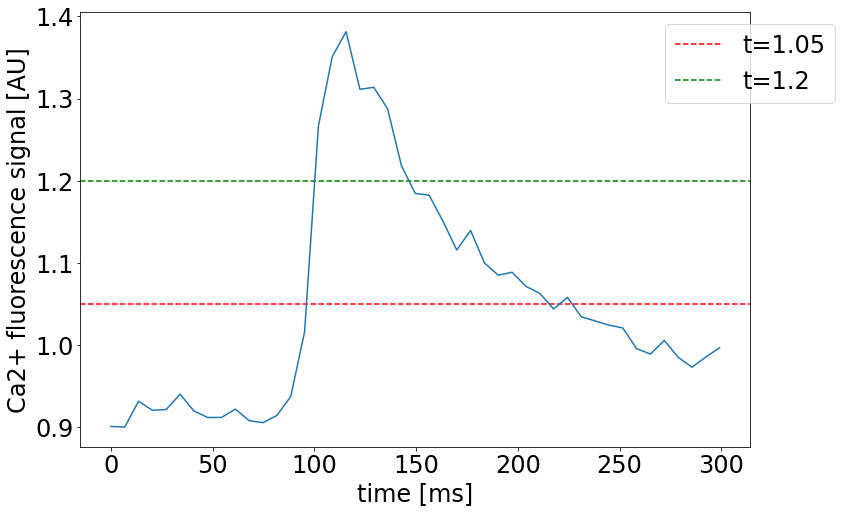

In [222]:
low_t = 1.05
high_t = 1.2

plt.rcParams.update({"font.size": 24})
plt.figure(figsize=(12, 8))

plt.axhline(y=low_t, color="r", linestyle="dashed", label=f"t={low_t}")
plt.axhline(y=high_t, color="g", linestyle="dashed", label=f"t={high_t}")
plt.plot(frames_ms, signal)

plt.xlabel("time [ms]")
plt.ylabel("Ca2+ fluorescence signal [AU]")
plt.legend(bbox_to_anchor=(1.0, 1), loc="upper center")

plt.savefig(os.path.join(out_dir, "event_thresholding.png"))

### get selected event annotated mask according to different thresholds

In [127]:
# get larger event ROI to allow a lower threshold
large_event_mask = binary_dilation(high_t_event_mask, iterations=20)
large_event_movie = np.where(large_event_mask, smooth_movie, 0)

In [119]:
high_t = 1.2
high_t_event_mask = large_event_movie > high_t

In [142]:
low_t = 1.05
low_t_event_mask = large_event_movie > low_t

### !!!! CLEANED LARGE EVENT ROI MANUALLY !!!!

In [143]:
viewer = napari.Viewer()
# viewer.theme = 'dark'
viewer.add_image(smooth_movie, name="smooth movie", colormap=("colors", cmap))

viewer.add_labels(preds, name="colored preds", visible=False)

viewer.add_labels(
    pred_mask,
    name="selected predicted event",
)

viewer.add_labels(large_event_mask, name="dilated predicted event", visible=False)

viewer.add_labels(
    low_t_event_mask,
    name="large annotated event",
)

viewer.add_labels(
    high_t_event_mask,
    name="small annotated event",
)

<Labels layer 'small annotated event' at 0x281abbac4c0>

### get 3D plot of selected event

In [164]:
# get event slices
rois_low_t = ndi.measurements.find_objects(low_t_event_mask)

In [161]:
event_peak

[96, 21, 305]

y start 4 y end 54 x start 274 x end 341


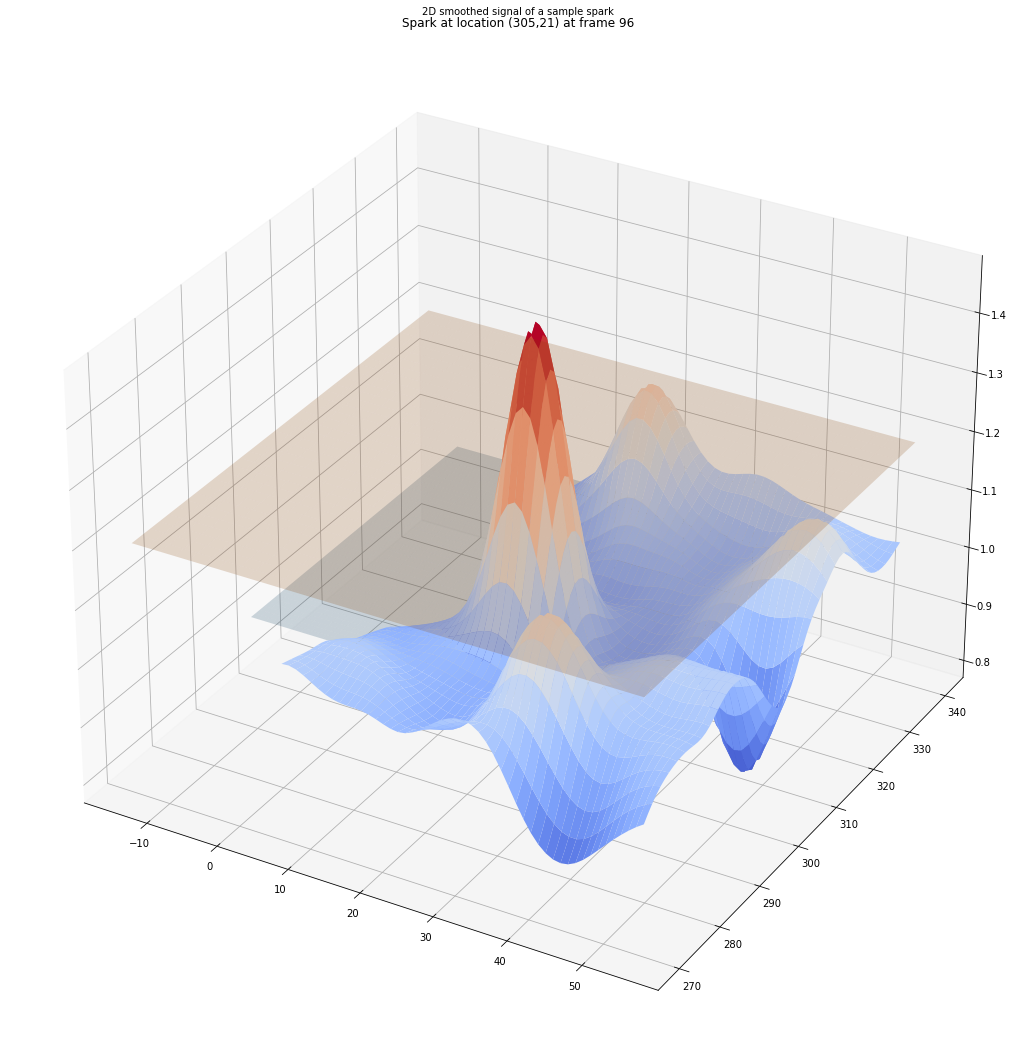

In [197]:
# Plot 2D signal
plt.figure(figsize=(15, 15))
# plt.rcParams.update({'font.size': 8})

plt.suptitle("2D smoothed signal of a sample spark", fontsize=10)

context = 10
low_peak_context = 25
high_peak_context = 35

t, y, x, y_frames, x_frames, signal_2d = get_spark_2d_signal(
    video=smooth_movie,
    slices=rois_low_t[0],
    coords=event_peak,
    spatial_context=context,
    sigma=0,
    return_info=True,
)
x_axis, y_axis = np.meshgrid(x_frames, y_frames)

ax = plt.subplot(1, 1, 1, projection="3d")
ax.set_title(f"Spark at location ({x},{y}) at frame {t}")


# add horizontal planes
low_x_frames = np.arange(x - low_peak_context, x + low_peak_context)
low_y_frames = np.arange(y - low_peak_context, y + low_peak_context)
low_x_axis, low_y_axis = np.meshgrid(low_x_frames, low_y_frames)
ax.plot_surface(low_y_axis, low_x_axis, low_x_axis * 0 + low_t, alpha=0.2)

high_x_frames = np.arange(x - high_peak_context, x + high_peak_context)
high_y_frames = np.arange(y - high_peak_context, y + high_peak_context)
high_x_axis, high_y_axis = np.meshgrid(high_x_frames, high_y_frames)
ax.plot_surface(high_y_axis, high_x_axis, high_x_axis * 0 + high_t, alpha=0.2)

# plot event
ax.plot_surface(
    y_axis, x_axis, signal_2d, cmap=cm.coolwarm, linewidth=0, alpha=1
)  # , antialiased=False)


plt.tight_layout()
plt.show()

In [174]:
x_axis.shape

(50, 67)

In [176]:
y_axis.shape

(50, 67)

### compute IoU and IoMin of selected event

In [146]:
iou_low_t = compute_iou(
    ys_roi=low_t_event_mask,
    preds_roi=pred_mask,  # ignore_mask=None
)

In [147]:
iou_low_t

0.5318324860808521

In [148]:
iou_high_t = compute_iou(
    ys_roi=high_t_event_mask,
    preds_roi=pred_mask,  # ignore_mask=None
)

In [149]:
iou_high_t

0.1615110867779907

In [150]:
iomin_low_t = compute_inter_min(
    ys_roi=low_t_event_mask,
    preds_roi=pred_mask,  # ignore_mask=None
)

In [151]:
iomin_low_t

0.8213084112149532

In [152]:
iomin_high_t = compute_inter_min(
    ys_roi=high_t_event_mask,
    preds_roi=pred_mask,  # ignore_mask=None
)

In [153]:
iomin_high_t

1.0

## Save tiff files as avi
I files .avi che salvo con ImageJ hanno una qualità terribile

In [240]:
movie_dir = "ORIGINAL_MOVIE_SAMPLES"
filename = "TEMP_new_annotated_peaks_physio_100000_34_original_movie.tif"
movie_f = os.path.join(movie_dir, filename)

In [241]:
out_dir = "annotations_figures"
out_f = os.path.join(out_dir, "34_original_movie_75fps_timestamps.avi")

In [242]:
movie_array = np.asarray(imageio.volread(movie_f))

In [243]:
np.shape(movie_array)

(892, 64, 512, 3)

In [244]:
# make array bigger
repeats = 3
movie_array_test = np.repeat(movie_array, repeats=repeats, axis=1)
movie_array_test = np.repeat(movie_array_test, repeats=repeats, axis=2)

In [245]:
movie_array_test = list(movie_array_test)

In [246]:
width = 512 * repeats
height = 64 * repeats

fps = 75

In [249]:
fourcc = cv2.VideoWriter_fourcc(*"DIVX")
out = cv2.VideoWriter(out_f, fourcc, fps, (width, height))

# absolute_max = np.iinfo(np.uint16).max
absolute_max = np.max(movie_array)

for frame in movie_array_test:
    # run this for RGB movies
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # run this for grayscale movies
    # frame = 255*(frame/absolute_max)
    # frame = np.uint8(frame)
    # frame = np.repeat(frame[..., None], 3, axis=-1)

    out.write(frame)
out.release()

## Add colored segmentation on sample .png frame

In [24]:
sample_f = "02_video_frame_462.png"
sample_path = os.path.join("movie_example", sample_f)
sample = np.asarray(imageio.volread(sample_path))

In [25]:
frame_labels = np.zeros_like(sample)[:, :, 0]

In [26]:
no_color = [0, 0, 0, 0]
green_spark = [178, 255, 102, 255]
red_puff = [255, 102, 102, 255]
purple_wave = [178, 102, 255, 255]

In [27]:
new_colormap = {
    "colors": [no_color, green_spark, red_puff, purple_wave],
    "name": "white_to_blue",
    "interpolation": "zero",
}

In [28]:
viewer.theme = "light"

In [29]:
viewer = napari.Viewer()
viewer.add_image(sample, name="sample frame")

labels = viewer.add_labels(frame_labels, name="segmentation")
labels.colormap = new_colormap

C:\Users\dotti\.conda\envs\sparks\lib\site-packages\napari\utils\colormaps\standardize_color.py:300: UserWarning: Colors with values larger than one detected. napari will normalize these colors for you. If you'd like to convert these yourself, please use the proper method from skimage.color.
  warnings.warn(


In [30]:
screenshot = viewer.screenshot()
# viewer.add_image(screenshot, rgb=True, name='screenshot')

In [11]:
out_dir = "movie_example"
out_f = os.path.join(out_dir, "colored_" + sample_f)

imsave(out_f, screenshot)

## Save examples of good and bad predictions on movies 05 and 34 -> done on "PREDS PROCESSING separate events.ipynb"

Idea:
- aprire le raw preds dei movies 05 e 34 e le annotazioni delle classi
- calcolare la segmentazione sulle preds
- visualizzare i risultati con Napari e fare lo screenshot di esempi di buone e cattive preds

In [4]:
movie_id = "05"

In [5]:
sparks_f = "TEMP_new_annotated_peaks_physio_100000_" + movie_id + "_sparks.tif"
puffs_f = "TEMP_new_annotated_peaks_physio_100000_" + movie_id + "_puffs.tif"
waves_f = "TEMP_new_annotated_peaks_physio_100000_" + movie_id + "_waves.tif"
ys_f = "TEMP_new_annotated_peaks_physio_100000_" + movie_id + "_ys.tif"
movie_dir = "ORIGINAL_MOVIE_SAMPLES"

In [13]:
xs_f = movie_id + "_video.tif"

In [6]:
sparks = np.asarray(imageio.volread(os.path.join(movie_dir, sparks_f)))
puffs = np.asarray(imageio.volread(os.path.join(movie_dir, puffs_f)))
waves = np.asarray(imageio.volread(os.path.join(movie_dir, waves_f)))

ys = np.asarray(imageio.volread(os.path.join(movie_dir, ys_f)))

In [14]:
xs = np.asarray(imageio.volread(os.path.join(movie_dir, xs_f)))

In [7]:
bg = 1 - sparks - puffs - waves

#### compute segmentation

In [9]:
preds = {"sparks": sparks, "puffs": puffs, "waves": waves, "background": bg}

In [10]:
class_preds = get_otsu_argmax_segmentation(preds, return_classes=False)

#### compute annotations contour, for Napari visualisation

##### need to dilate and erode each class separately

In [35]:
contour_val = 2

In [37]:
# dilate only along x and y
struct = np.zeros((1, 1 + contour_val, 1 + contour_val))
struct[0, 1, :] = 1
struct[0, :, 1] = 1

In [59]:
ys_contour = np.zeros_like(ys)

for class_nb in range(1, 5):
    class_ys = ys == class_nb
    class_dilated = binary_dilation(class_ys, structure=struct)
    class_eroded = binary_erosion(class_ys, structure=struct)
    class_contour = np.where(
        np.logical_not(class_eroded.astype(bool)), class_dilated, 0
    )
    ys_contour += class_nb * class_contour.astype(ys_contour.dtype)

#### visualise results with Napari

In [26]:
cmap = get_discrete_cmap(name="gray", lut=16)

In [65]:
no_color = [0, 0, 0, 0]
green_spark = [178 / 255, 255 / 255, 102 / 255, 1]
red_puff = [255 / 255, 102 / 255, 102 / 255, 1]
purple_wave = [178 / 255, 102 / 255, 255 / 255, 1]
grey_ignore = [224 / 255, 224 / 255, 224 / 255, 1]
black = [1, 1, 1, 1]

In [66]:
labels_cmap = {
    0: no_color,
    1: green_spark,
    2: purple_wave,
    3: red_puff,
    4: grey_ignore,
    5: black,
}

In [63]:
viewer = napari.Viewer()
viewer.theme = "light"

viewer.add_image(xs, name="movie", colormap=("colors", cmap))

preds = viewer.add_labels(
    class_preds, name="class preds", color=labels_cmap, opacity=0.3
)

labels = viewer.add_labels(
    ys_contour, name="class annotations", color=labels_cmap, opacity=1
)

In [ ]:
screenshot = viewer.screenshot()
# viewer.add_image(screenshot, rgb=True, name='screenshot')

In [ ]:
# out_dir = "movie_example"
out_dir = "unet_predictions_figures"
out_f = os.path.join(out_dir, "colored_class_preds.png")

imsave(out_f, screenshot)

#### save 3d image of annotations with correct colors

##### add "borders" to ys 

In [81]:
white = 1  # black

In [84]:
ys_borders = np.zeros_like(ys)
set_edges_to_white(input_movie=ys_borders, white=white, thickness=2)

In [80]:
labels = viewer.add_labels(ys, name="class pred", color=labels_cmap, opacity=1)

In [85]:
labels = viewer.add_labels(
    ys_borders,
    name="borders",
    # color=labels_cmap,
    opacity=1,
)

In [88]:
screenshot = viewer.screenshot()
# viewer.add_image(screenshot, rgb=True, name='screenshot')

In [89]:
# out_dir = "movie_example"
out_dir = "unet_predictions_figures"
out_f = os.path.join(out_dir, "colored_class_preds.png")

imsave(out_f, screenshot)

## Generate IoU and IoMin examples with shapes

Idea: creo degli esempi 2D di annotazioni e preds (rotondi) e calcolo il loro IoU e IoMin score

- --> devo generare delle binary masks (della stessa dimensione) che contengono dei cerchi
- --> devo visualizzarli con Napari e fare lo screenshot 
- --> devo calcolare gli scores per tutti gli esempi che creo

In [192]:
# create empty background
y = np.zeros((64, 64), dtype=int)
pred = np.copy(y)

# set annotation and pred center
y_centre = (32, 44)
pred_centre = (32, 32)

# set annotation and pred radius
y_r = 10
pred_r = 30

# create ball shape
y_ball_coords = ball(y_centre, y_r)
pred_ball_coords = ball(pred_centre, pred_r)

# add ball to background
for coord in y_ball_coords:
    y[coord] = 2
for coord in pred_ball_coords:
    pred[coord] = 1

In [193]:
# compute iou and iomin scores
iou = compute_iou(ys_roi=y, preds_roi=pred)
iomin = compute_inter_min(ys_roi=y, preds_roi=pred)

In [194]:
iou, iomin

(0.11237149946827366, 1.0)

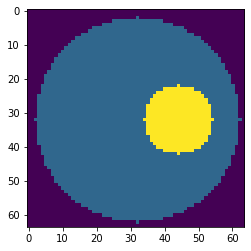

In [195]:
plt.imshow(y + pred)

#### visualise with Napari

In [97]:
no_color = [0, 0, 0, 0]
light_green = [178 / 255, 255 / 255, 102 / 255, 1]
dark_green = [34 / 255, 139 / 255, 34 / 255]
black = [1, 1, 1, 1]

labels_cmap = {0: no_color, 1: light_green, 2: dark_green, 3: black}

In [98]:
viewer = napari.Viewer()
viewer.theme = "light"

In [196]:
viewer.add_labels(y, name="y", color=labels_cmap, opacity=0.8)

viewer.add_labels(pred, name="pred", color=labels_cmap, opacity=0.8)

<Labels layer 'pred' at 0x2ca20b24df0>

In [197]:
screenshot = viewer.screenshot()
# viewer.add_image(screenshot, rgb=True, name='screenshot')

In [198]:
# out_dir = "movie_example"
out_dir = "results"
out_f = os.path.join(
    out_dir, f"y_r_{y_r}_pred_r_{pred_r}_iou_{iou:.3}_iomin_{iomin:.3}.png"
)

imsave(out_f, screenshot)

f"y_r_{y_r}_pred_r_{pred_r}_iou_{iou:.3}_iomin_{iomin:.3}.png"

'y_r_10_pred_r_30_iou_0.112_iomin_1.0.png'